# Задание
Что сделать:
необходимо проанализировать использование фильтров пользователями на страницах городов. вопросы, на которые стоит ответить:
- сколько людей пользуются фильтрами? 
- в каких городах фильтрами пользуются больше? в каких меньше? 
- какие разделы фильтров наиболее востребованы? “фильтры”, “сортировка”, “категории”? 
- как часто люди пользуются выбором цены? 
- как часто люди фильтруют по ценам? по датам? 
- какие фильтры лишние, невостребованные? 

не обязательно: любые дополнительные инсайты, полученные в результате исследования, будут плюсом к выполнению тестового задания. 

*важно! в event label много грязных данных. оттуда можно убрать числа. там могут встречаться разные вещи. это нормально, поступай с этим так, как тебе покажется правильным

In [1]:
import pandas as pd
import numpy as np

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
sns.set (
    font_scale =1.3,
    style = 'whitegrid',
    rc= {'figure.figsize': (22,7)}
)

Загружаю и смотрю дф

In [3]:
df_events = pd.read_csv('C:/Users/cbata/test_cases/sputnik8/events filters к тестовому 2022.csv')

In [4]:
df_events.head()

,event_category,event_action,event_label,total_events,unique_events
0,city_landing,price_button_submit,Tula / Показать предложения (11),8,7
1,city_landing,price_button_submit,Sochi / Показать предложения (39),12,10
2,city_landing,search-tools-button_open,Penza / Сортировка,2,2
3,city_landing,filters-categories_click,Gelendzhik / ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,1,1
4,city_landing,price_button_submit,Moscow / Показать предложения (345),2,2


Несмотря на то, что в описании к заданию содержимое некоторых колонок освещено, хочется всё равно посмотреть это вручную

In [5]:
df_events.event_category.value_counts()

city_landing    18441
City Page         651
Name: event_category, dtype: int64

In [6]:
df_events.event_action.value_counts()

price_button_submit         7354
search-tools-button_open    4848
filters-categories_click    3352
ticket-type_checkbox         795
Page Visit                   651
dates_filter_mobile          425
start_date_click             299
price_button_close           277
end_date_click               274
pay-type_checkbox            239
price_first                  186
clear_filter_mobile          165
price_second                 126
price_third                  101
Name: event_action, dtype: int64

In [7]:
def get_info(df): #функция для получения shape, types и количества NAN в колонках
    shape = df.shape
    types = df.dtypes
    isna_sum = df.isna().sum()
    dict = {"shape": shape, "types":types, "NAN" : isna_sum}
    return dict

In [8]:
get_info(df_events)

{'shape': (19092, 5),
 'types': event_category    object
 event_action      object
 event_label       object
 total_events       int64
 unique_events      int64
 dtype: object,
 'NAN': event_category    0
 event_action      0
 event_label       0
 total_events      0
 unique_events     0
 dtype: int64}

Типы на месте, даже без дф даже без NaN!

Итак, можно перейти к первому вопросу. **Сколько людей пользуются фильтрами?** Согласно описаю event_action в гугл доке, price_button_submit отражает факт нажатия на кнопку "Показать предложения". Смотрим!

In [9]:
filter_users = df_events.query('event_action == "price_button_submit"').agg({'unique_events': 'sum'})

In [10]:
filter_users

unique_events    63063
dtype: int64

Итак, фильтрами пользуется 63063 уникальных пользователя. Но что значат эти цифры сами по себе? Стоит посмотреть соотношение числу посещений страницы

In [11]:
visitors = df_events.query('event_action == "Page Visit"').agg({'unique_events': 'sum'})

In [12]:
visitors

unique_events    1384478
dtype: int64

Само соотношение, в процентах:

In [13]:
round((filter_users / visitors) *100, 2)

unique_events    4.56
dtype: float64

Вот так намного понятнее.

**Вывод**

**63063** уникальных пользователя воспользовались фильтром. Относительно числа уникальных пользователей, посещавших страницы, они составляют **4.56%** 

Для наглядности также можно построить график:

In [14]:
df_visits_and_filters = df_events.query('(event_action == "price_button_submit") | (event_action == "Page Visit")')

Text(0.5, 1.0, 'Применившие фильтр пользователи и посетившие страницу пользователи')

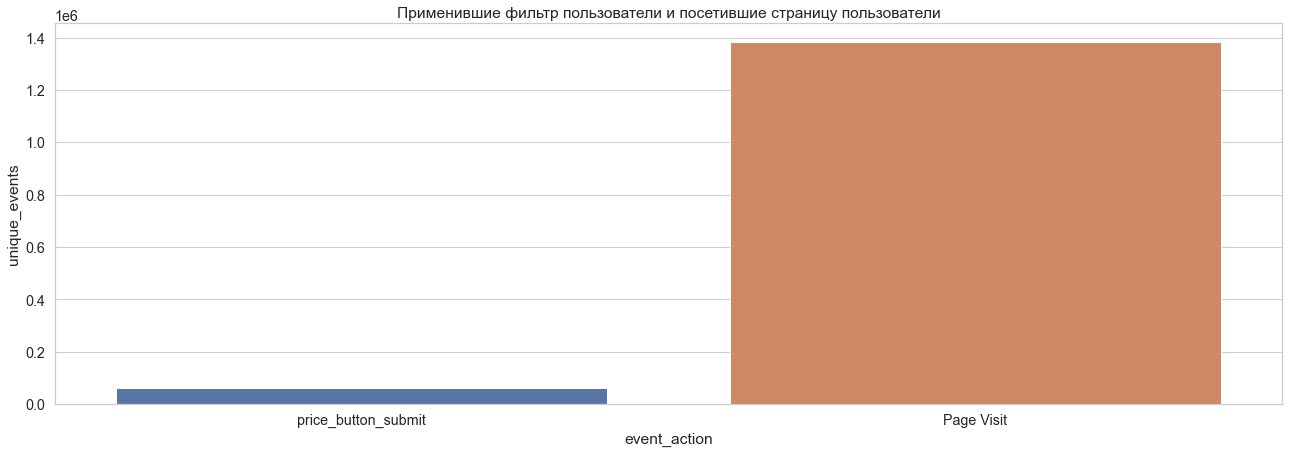

In [15]:
sns.barplot(data = df_visits_and_filters, x= 'event_action',
            y = 'unique_events', estimator = sum, ci=None)
plt.title('Применившие фильтр пользователи и посетившие страницу пользователи')

**В каких городах фильтрами пользуются больше? в каких меньше?**

Для начала извлечём город из event_label в отдельную колонку

In [16]:
df_events['city'] = df_events.event_label.apply(lambda x: x.split(' ')[0])

In [17]:
df_events.head(3)

,event_category,event_action,event_label,total_events,unique_events,city
0,city_landing,price_button_submit,Tula / Показать предложения (11),8,7,Tula
1,city_landing,price_button_submit,Sochi / Показать предложения (39),12,10,Sochi
2,city_landing,search-tools-button_open,Penza / Сортировка,2,2,Penza


Я решила, что имеет смысл рассчитать и уникальных пользователей, и общее количество применений.

In [18]:
df_cities_filters = df_events.groupby('city', as_index=False).agg({'unique_events': 'sum','total_events': 'sum'}) \
    .sort_values(by = ['unique_events','total_events'], ascending =False)

In [19]:
df_cities_filters

,city,unique_events,total_events
466,Saint,255673,380566
364,Moscow,150056,221407
248,Kaliningrad,93235,142957
260,Kazan,60191,84567
507,Sochi,53001,79340
...,...,...,...
566,Uganda,1,1
569,Ulm,1,1
597,Waikabubak,1,1
619,Zanzibar,1,1


Построим графики, отражающие общую тенденцию. Они будут немнного страшными из-за большого количества городов, но покажут общую картину.

<ipython-input-20-ece60c954f03>:3: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(['unique_events', 'total_events'], labels = ['unique_events', 'total_events'])


Text(0.5, 1.0, 'Применение фильтров и города')

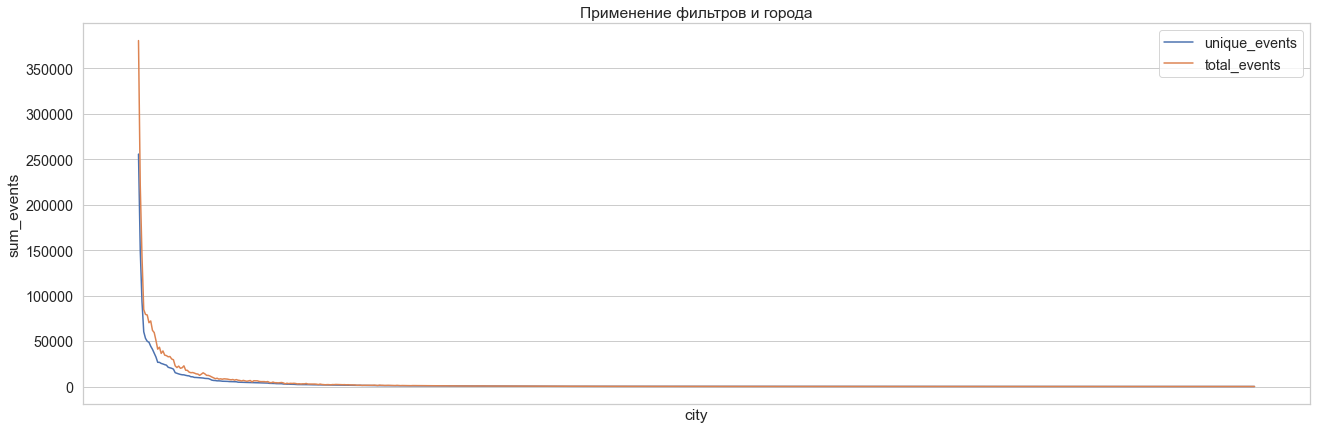

In [20]:
sns.lineplot(data = df_cities_filters , x='city', y =  'unique_events')
sns.lineplot(data = df_cities_filters , x='city', y =  'total_events')
plt.legend(['unique_events', 'total_events'], labels = ['unique_events', 'total_events'])
plt.ylabel('sum_events')
plt.xticks([])
plt.title('Применение фильтров и города')

Пусть будет отобрано 10 первых городов

In [21]:
top_10_cities_filters = df_cities_filters.head(10)

In [22]:
top_10_cities_filters

,city,unique_events,total_events
466,Saint,255673,380566
364,Moscow,150056,221407
248,Kaliningrad,93235,142957
260,Kazan,60191,84567
507,Sochi,53001,79340
494,Sharm-el-Sheikh,49758,78691
237,Istanbul,48650,70160
25,Anapa,44284,72101
158,Dubai,40891,61765
230,Hurghada,36542,59339


Самые непопулярные города в плане использования фильтров я вычислю по-другому: через единички

In [23]:
bottom_cities_filters = df_cities_filters.query('total_events ==1')

In [82]:
print(bottom_cities_filters.city.tolist())

['Agrigento', 'Alkmaar', 'Aosta', 'Bagan', 'Bagrationovsk', 'Boca', 'Bolgheri', 'Burgos', 'Cabarete', 'Crimea', 'Denpasar', 'Ganja', 'Gatchina', 'Gianyar', 'Heidelberg', 'Kampala', 'Leh', 'Maloyaroslavets', 'Messina', 'Mombasa', 'Moshi', 'Mytishchi', 'Portofino', 'Pravdinsk', 'Puerto', 'Putao', 'Sarapul', 'Severodvinsk', 'Torredembarra', 'Totma', 'Trento', 'Turkistan', 'Uganda', 'Ulm', 'Waikabubak', 'Zanzibar', 'pokrov']


**Вывод**

Как видим, абсолютным лидером по фильтрам является Санкт-Петербург. Unique_events взаимосвязано с total_events, что закономерно.

Text(0.5, 1.0, 'Топ-10 городов по фильтрации')

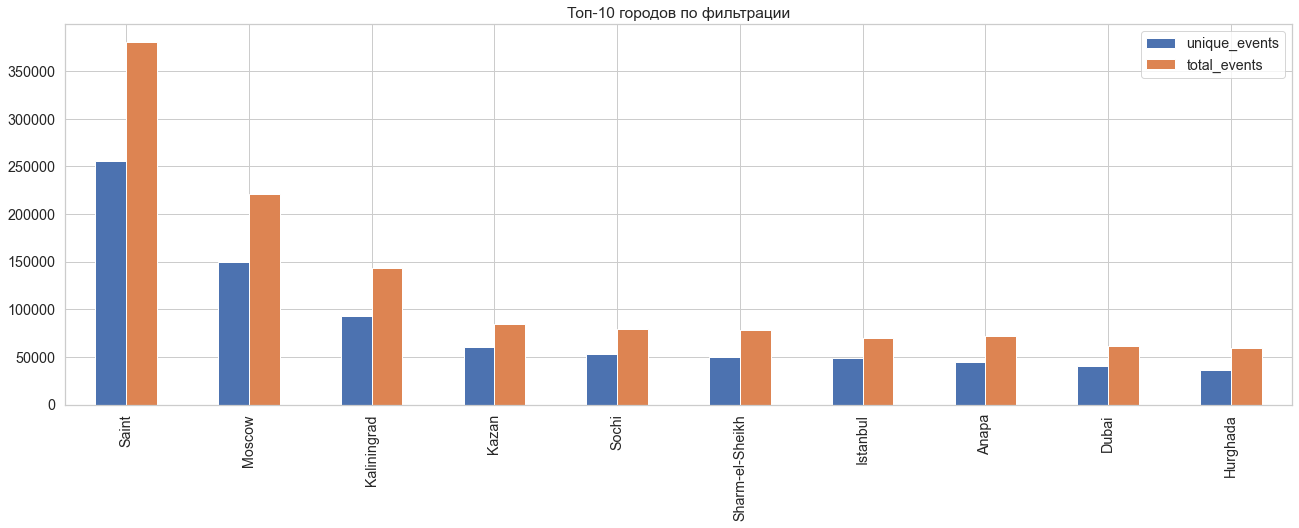

In [25]:
top_10_cities_filters.plot.bar(x ='city')
plt.xlabel('')
plt.title('Топ-10 городов по фильтрации')

**Какие разделы фильтров наиболее востребованы? “фильтры”, “сортировка”, “категории”?**

У нас есть колонка event_label, отражающая текст на кнопке. Кнопки "Сортировка", "Категории", "Фильтры", есть на сайте их можно вытащить из event_label. Создам новую колонку с очищенными лейблами - label_value

Сразу отмечу, что востребованность разделов фильтра буду оценивать через уникальных пользователей. Люди - наше всё!

In [26]:
df_events.head()

,event_category,event_action,event_label,total_events,unique_events,city
0,city_landing,price_button_submit,Tula / Показать предложения (11),8,7,Tula
1,city_landing,price_button_submit,Sochi / Показать предложения (39),12,10,Sochi
2,city_landing,search-tools-button_open,Penza / Сортировка,2,2,Penza
3,city_landing,filters-categories_click,Gelendzhik / ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,1,1,Gelendzhik
4,city_landing,price_button_submit,Moscow / Показать предложения (345),2,2,Moscow


In [27]:
df_events['label_value'] = df_events.event_label.apply(lambda x: x.split('/ ')[-1])

In [28]:
df_events.head()

,event_category,event_action,event_label,total_events,unique_events,city,label_value
0,city_landing,price_button_submit,Tula / Показать предложения (11),8,7,Tula,Показать предложения (11)
1,city_landing,price_button_submit,Sochi / Показать предложения (39),12,10,Sochi,Показать предложения (39)
2,city_landing,search-tools-button_open,Penza / Сортировка,2,2,Penza,Сортировка
3,city_landing,filters-categories_click,Gelendzhik / ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,1,1,Gelendzhik,ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ
4,city_landing,price_button_submit,Moscow / Показать предложения (345),2,2,Moscow,Показать предложения (345)


Теперь можно отобрать клики на категории, фильтры и сортировку, для этого создам новый дф

In [29]:
df_filters_types = df_events[['unique_events', 'label_value']].query('label_value == "Категории" | label_value == "Сортировка" | label_value == "Фильтры"')

In [30]:
df_filters_types.head(3)

,unique_events,label_value
2,2,Сортировка
54,4,Категории
60,1,Категории


In [31]:
df_filters_types.groupby('label_value', as_index = False).agg({'unique_events': 'sum'})

,label_value,unique_events
0,Категории,9329
1,Сортировка,7556
2,Фильтры,17188


Text(0.5, 1.0, 'Уникальные ивенты, сумма')

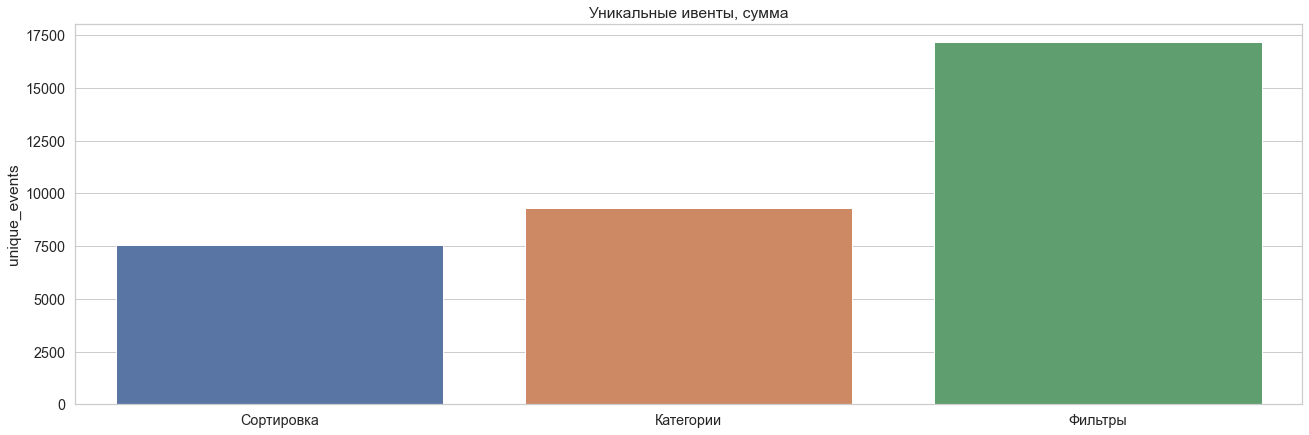

In [32]:
sns.barplot(data = df_filters_types, x = 'label_value', y = 'unique_events', estimator = sum, ci = None )
plt.xlabel('')
plt.title('Уникальные ивенты, сумма')

Числа - это хорошо, но можно проверить различия ещё и с помощью статистики.
Для начала посмотрю распределения уников по каждому типу фильтрации. Начну с сортировки.

Text(0.5, 1.0, 'Фильтры')

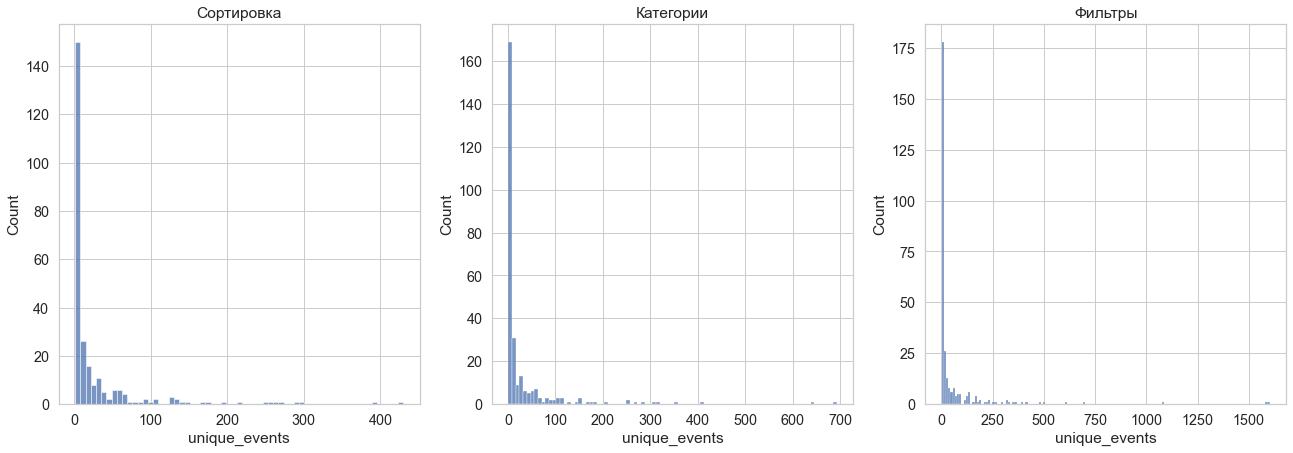

In [33]:
f, axes = plt.subplots(1, 3)
sns.histplot(data = df_filters_types.query('label_value== "Сортировка"') , x='unique_events', ax=axes[0])
sns.histplot(data = df_filters_types.query('label_value== "Категории"') , x='unique_events', ax=axes[1])
sns.histplot(data = df_filters_types.query('label_value== "Фильтры"') , x='unique_events', ax=axes[2])
axes[0].set_title("Сортировка")
axes[1].set_title("Категории")
axes[2].set_title("Фильтры")

In [34]:
print('sort_sample_size =', df_filters_types.query('label_value== "Сортировка"').shape[0])
print('categories_sample_size =', df_filters_types.query('label_value== "Категории"').shape[0])
print('filt_sample_size =', df_filters_types.query('label_value== "Фильтры"').shape[0])

sort_sample_size = 261
categories_sample_size = 282
filt_sample_size = 294


Сразу видно, что распределение кликов само по себе не нормально и имеет выбросы в каждом из случаев. Такова природа распределения кликов, и мне потребовалось время, чтобы принять решение по поводу статистического метода. 

В результате я выбрала t тест, так как посчитала, что выборки достаточно большие(261), чтобы пренебречь их нормальностью. Также одинаковое распределение выборок говорит об их однородности, потому я решила, что имеет смысл оценить средние. Из альтернатив есть Манна-Уитни и Краскела — Уоллиса, но я изебагаю их из-за неоднозначности интерпретации и меньшей мощности. От ANOVA же я отказалась, так как ANOVA более чувствительна к нормальности.

Выравниваю количество наблюдений в выборках по наименьшей(Сортировка)

In [35]:
min_sample_size = df_filters_types.query('label_value== "Сортировка"').shape[0]

In [36]:
sort_sample = df_filters_types.query('label_value== "Сортировка"').unique_events

In [37]:
categories_sample = df_filters_types.query('label_value== "Категории"').unique_events.sample(n=min_sample_size, random_state=42)

In [38]:
filters_sample = df_filters_types.query('label_value== "Фильтры"').unique_events.sample(n=min_sample_size, random_state=42)

In [39]:
stats.ttest_ind(sort_sample, categories_sample,  equal_var = False)

Ttest_indResult(statistic=-0.7076006693588016, pvalue=0.47953599550359416)

Вывод: p = 0.47, p>0.05, нулевая гипотеза не отклонена. Статистически значимой разницы средних количества уникальных пользователей, кликнувших на сортировку, и количества уникальных пользователей, кликнувших на категории, не выявлено.

In [40]:
stats.ttest_ind(sort_sample, filters_sample ,  equal_var = False)

Ttest_indResult(statistic=-2.5812234832464847, pvalue=0.010257897934180733)

Вывод: p = 0.01, p<0.05, отклоняем нулевую гипотезу. Выявлена статистически значимая разница средних количества уникальных пользователей, кликнувших на сортировку, и количества уникальных пользователей, кликнувших на фильтры.

In [41]:
stats.ttest_ind(categories_sample, filters_sample ,  equal_var = False)

Ttest_indResult(statistic=-2.0213802983121947, pvalue=0.043900667648088254)

Вывод: p = 0.043, p<0.05, отклоняем нулевую гипотезу. Выявлена статистически значимая разница средних количества уникальных пользователей, кликнувших на категории, и количества уникальных пользователей, кликнувших на фильтры.

Одно из p = 0.043, что очень близко к границе. Помочь дополнительно оценить статистическую значимость разницы можно с помощью графика

<AxesSubplot:xlabel='label_value', ylabel='unique_events'>

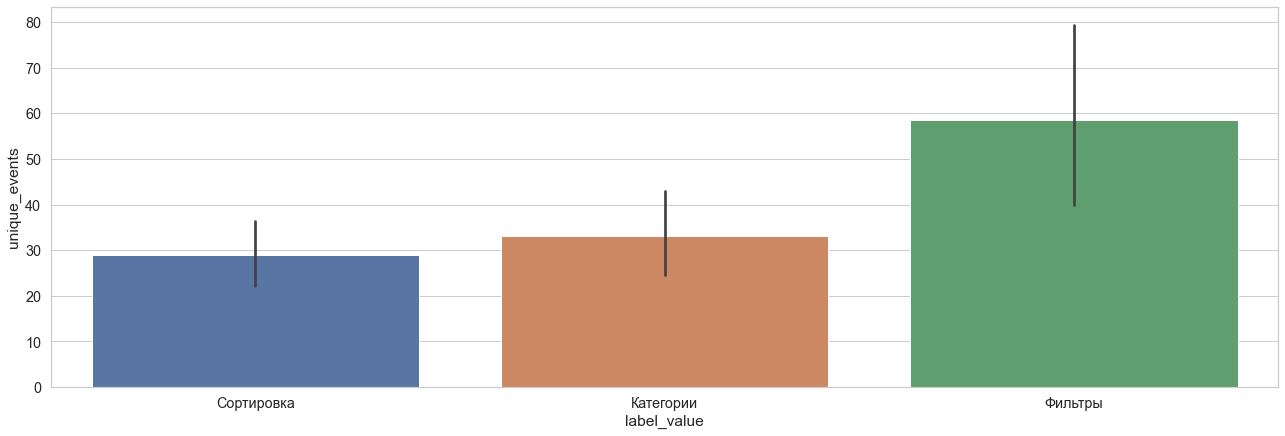

In [42]:
sns.barplot(data = df_filters_types, x = 'label_value', y = 'unique_events' )

Видно следующее: доверительные интервалы средних для Сортировки и Категорий перекрываются, а так же для Категорий и Фильтров. Всё ещё остаётся статистически значимая разница между Сортировкой и Фильтрами.

**Вывод**

Если смотреть просто на суммы уникальных действий, то наиболее востребованным видом фильтрации являются фильтры, затем категории, и затем сортировка. Статистически значимой разница средних оказалась только для пары Фильтры-Сортировка. В общем и целом, фильтры всё же можно посчитать самым востребованном разделом.

**Как часто люди пользуются выбором цены?**

В event_action выбору цены соответсвуют price_first, price_second,  price_third

In [43]:
prices_df = df_events.query('event_action == "price_first" | event_action == "price_second" | event_action == "price_third"')

In [44]:
prices_events_df = prices_df.groupby('event_action', as_index = False).agg({'total_events' :'sum', 'unique_events' :'sum'})

In [45]:
prices_events_df 

,event_action,total_events,unique_events
0,price_first,8572,6676
1,price_second,2826,1995
2,price_third,904,595


Добавлю пропорции:

In [46]:
prices_events_df['total_events_proportion'] = round(prices_events_df.total_events / prices_events_df.total_events.sum() *100, 2)

In [47]:
prices_events_df['unique_events_proportion'] = round(prices_events_df.unique_events / prices_events_df.unique_events.sum() *100, 2)

In [48]:
prices_events_df

,event_action,total_events,unique_events,total_events_proportion,unique_events_proportion
0,price_first,8572,6676,69.68,72.05
1,price_second,2826,1995,22.97,21.53
2,price_third,904,595,7.35,6.42


**Вывод**

Результаты вполне ожидаемы: чаще всего люди используют первый фильтр по цене, отбирая предложения дешевле, за ним идёт второй и третий. Это справедливо и для total_events и для unique_events

График:

Text(0.5, 1.0, 'Фильтр цены')

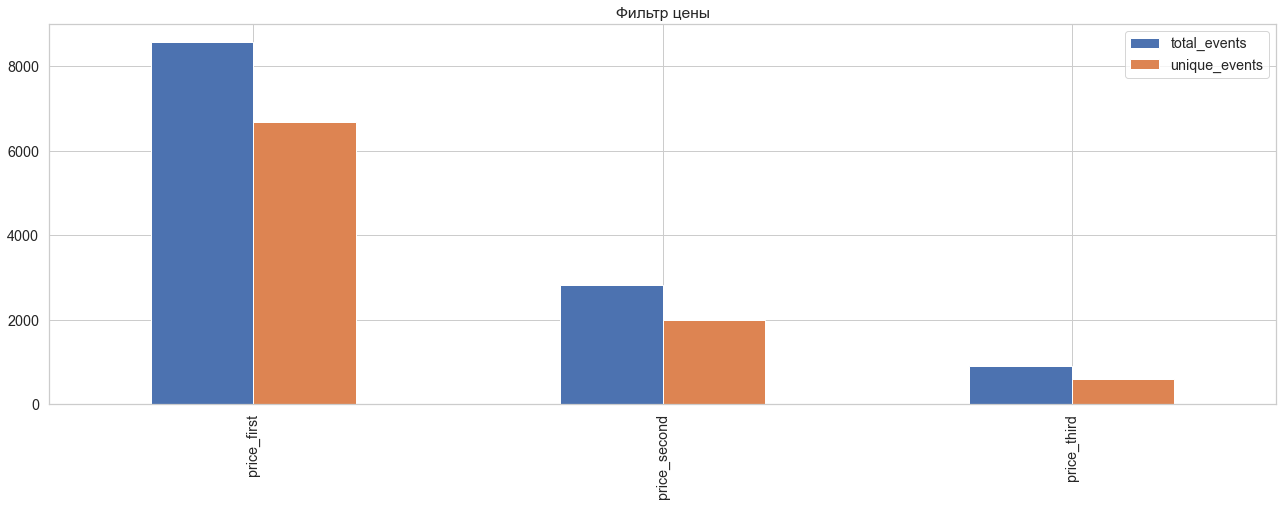

In [49]:
prices_events_df[['event_action','total_events', 'unique_events']].plot.bar(x ='event_action')
plt.xlabel('')
plt.title('Фильтр цены')

**Как часто люди фильтруют по ценам? по датам?**

Для ответа на вопрос фильтрации по ценам есть ранее сформированный датасет

In [50]:
prices_events_df

,event_action,total_events,unique_events,total_events_proportion,unique_events_proportion
0,price_first,8572,6676,69.68,72.05
1,price_second,2826,1995,22.97,21.53
2,price_third,904,595,7.35,6.42


In [84]:
print('всего событий = ', prices_events_df.total_events.sum())

всего событий =  12302


In [85]:
print('всего уникальных событий = ', prices_events_df.unique_events.sum())

всего уникальных событий =  9266


Для оценки фильтрации по датам в документации есть два три event_action - start_date_click and end_date_click , dates_filter_mobile - дополнительные кнопки со значениями сегодня-завтра.

In [69]:
df_date_filter = df_events.query('event_action == "start_date_click" | event_action == "end_date_click" | event_action == "dates_filter_mobile"').groupby('event_action', as_index = False) \
    .agg({'total_events' :'sum', 'unique_events': 'sum'})

In [70]:
df_date_filter['total_events_proportion'] = round(df_date_filter.total_events / df_date_filter.total_events.sum() *100, 2)

In [71]:
df_date_filter['unique_events_proportion'] = round(df_date_filter.unique_events / df_date_filter.unique_events.sum() *100, 2)

In [72]:
df_date_filter 

,event_action,total_events,unique_events,total_events_proportion,unique_events_proportion
0,dates_filter_mobile,13038,10272,27.38,28.13
1,end_date_click,14638,11738,30.74,32.15
2,start_date_click,19939,14501,41.88,39.72


**Вывод**


Для цен: чаще всего люди используют первый фильтр по цене, отбирая предложения дешевле, за ним идёт второй и третий. Это справедливо и для total_events и для unique_events

Для даты: фильтрами даты пользуются чаще, чем фильтрами цены. Число поставивших первую дату больше, чем число поставивших вторую дату(завершения).Это может быть связано как с оттоком пользователей, так и с особенностями интерфейса: например, первая дата уже проставлена, потому остаётся лишь добавить вторую.
Также интересно, что много людей пользуется кнопками сегодня/завтра,их число практически не уступает числу, пользующихся фильтрами даты.

Text(0.5, 1.0, 'Фильтры дат')

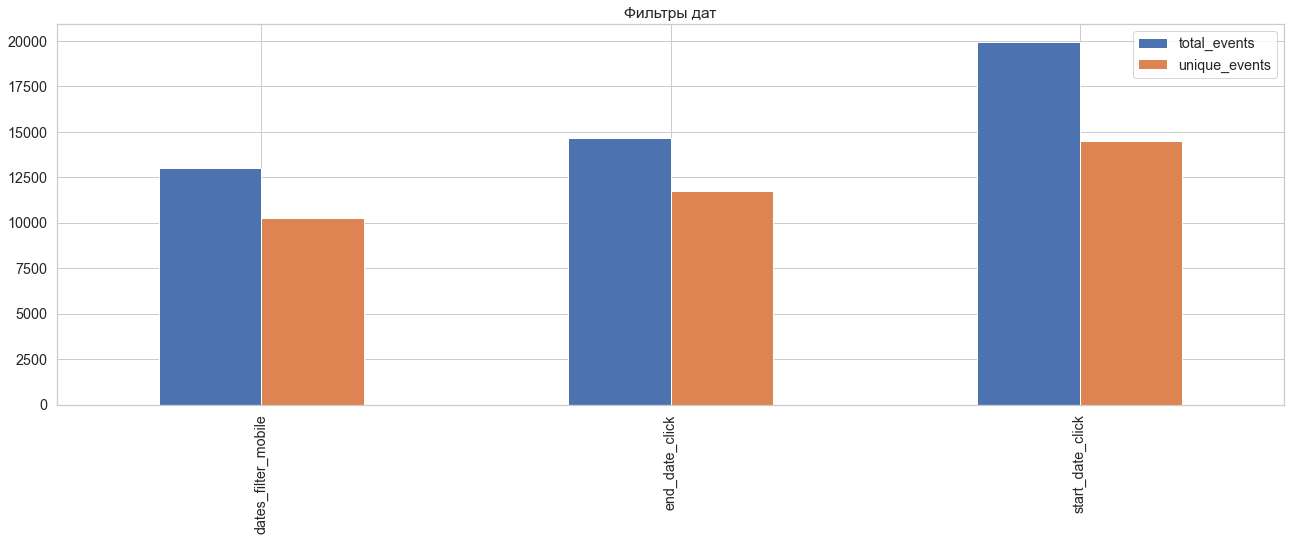

In [73]:
df_date_filter [['event_action','total_events', 'unique_events']].plot.bar(x ='event_action')
plt.xlabel('')
plt.title('Фильтры дат')

**Какие фильтры лишние, невостребованные?**

Интересный вопрос! Из заданий ранее вспомнилось только два элемента с наименьшим количеством кликов - это третья категория цены(большие цены) и сортировка.

In [75]:
df_filters_types.groupby('label_value', as_index = False).agg({'unique_events': 'sum'})

,label_value,unique_events
0,Категории,9329
1,Сортировка,7556
2,Фильтры,17188


In [76]:
prices_events_df 

,event_action,total_events,unique_events,total_events_proportion,unique_events_proportion
0,price_first,8572,6676,69.68,72.05
1,price_second,2826,1995,22.97,21.53
2,price_third,904,595,7.35,6.42


Тем не менее, не осмелюсь назвать лишними ни то, ни другое: сортировка всё равно важный элементлюбого интерфейса. Другое дело, что ей ставят активно значение по умолчанию "популярное", которое к некоторой степени вмещает в себя и доступную цену(популярное значит, что и доступное для многих людей).
С третьим чекбоксом цены то же самое - учитывая то, какой может быть средний чек пользователей, которые выбирают самые дорогие экскурсии, признать его просто лишним нельзя.

В документации есть ранее неупомянутые в заданиях pay-type_checkbox- оплата наличными и ticket-type_checkbox - тип экскурсии(индивидуальная, группа). Можно посмотреть их, хотя я сразу могу сказать, что сомневаюсь, что тип группы может быть невостребованным

In [78]:
df_events.query('event_action == "pay-type_checkbox" | event_action == "ticket-type_checkbox"').groupby('event_action', as_index = False) \
    .agg({'total_events' :'sum', 'unique_events': 'sum'})

,event_action,total_events,unique_events
0,pay-type_checkbox,7321,5465
1,ticket-type_checkbox,22882,17918


Как видим, ticket-type_checkbox как раз очень популярен, а вот оплата наличными... Учитывая то, что 5456 - это точно максимальное число уникальных пльзователей, кликнувших на этот фильтр, он кажется лишним. Например, у той же сортировки, как я уже описывала, может быть подходящее исходное значения для пользователя, потому на неё не жмут часто - и так удобно. С оплатой наличными такого нет.

**Вывод** 

Так что если ставить вопрос о лишних фильтрах, то **оплата наличными может являться лишним фильтром**